# Detect minor in a picture

### Introduction

Notebook to train a model that will detect if there is a minor in a picture. Creates several models and compares them to choose the best one.

### Imports and global variables

In [7]:
# Global imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.src.utils import image_dataset_from_directory
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.proportion import proportion_confint
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input, BatchNormalization
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Recall
from tensorflow.keras.models import Sequential, Model

In [8]:
RANDOM_SEED = 2_055
IMG_SIZE = (200, 200, 3)
BATCH_SIZE = 32
VALIDATION_SPLIT = .2
AUTOTUNE = tf.data.AUTOTUNE

Choose one of the two following cells, depending on if using Google Collab or local paths.

In [9]:
# Google collab specific
from google.colab import drive
drive.mount('/content/drive')
PATH_TRAIN_DATASET = '/content/drive/My Drive/FaceBlur/face_age'
PATH_MODELS = '/content/drive/My Drive/FaceBlur/models'
PATH_16_17_DATASET = '/content/drive/My Drive/FaceBlur/face_age_16_17'

Mounted at /content/drive


In [10]:
# # Local paths
# PATH_TRAIN_DATASET = './../data/face_age_reduced'
# PATH_MODELS = './../models'
# PATH_16_17_DATASET = './../data/face_age_16_17'

### Create datasets

Divide the dataset into train and validation.

In [11]:
def scaling_normalization(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

In [12]:
train_dataset = image_dataset_from_directory(
    PATH_TRAIN_DATASET,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    PATH_TRAIN_DATASET,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

train_dataset = train_dataset.map(scaling_normalization)
validation_dataset = validation_dataset.map(scaling_normalization)

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 9779 files belonging to 2 classes.
Using 7824 files for training.
Found 9779 files belonging to 2 classes.
Using 1955 files for validation.


A third dataset is created with only 16 and 17 yo pictures.

In [13]:
# Dataset with only 16 and 17 yo
minor_16_17_dataset = image_dataset_from_directory(
    PATH_16_17_DATASET,
    image_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE
)

minor_16_17_dataset = minor_16_17_dataset.map(scaling_normalization)
minor_16_17_ds = minor_16_17_dataset.prefetch(buffer_size=AUTOTUNE)

Found 50 files belonging to 2 classes.


# Model training

Creates different models with different hyperparameters and trains them.

In [14]:
def compile_fit_model(train, validation, learning_rate: float, batch_size: int,
                      batch_normalization: False, model_name: str) -> Sequential:
    model = Sequential()

    # First convolutional block
    model.add(Input(shape=IMG_SIZE))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Transform convolutional block to a vector
    model.add(GlobalAveragePooling2D())

    # Dense hidden layer
    model.add(Dense(32, activation='relu'))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            Recall(name='recall'),
            TruePositives(name='tp'),
            TrueNegatives(name='tn'),
            FalsePositives(name='fp'),
            FalseNegatives(name='fn'),
        ]
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{PATH_MODELS}/{model_name}.keras',
        save_best_only=True,
        monitor='val_recall',
        mode='max',
    )

    history = model.fit(train, validation_data=validation, epochs=5, batch_size=batch_size, verbose=True,
                        callbacks=[model_checkpoint])

    return model, history

**Model 1**
- Learning rate: 0.01
- Batch normalization: False
- Batch size: 32

In [15]:
model_1, history_1 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=False, batch_size=32, model_name='model_1'
)

Epoch 1/5
245/245 [==============================] - 628s 2s/step - loss: 1.7527 - recall: 0.0199 - tp: 62.0000 - tn: 4618.0000 - fp: 98.0000 - fn: 3046.0000 - val_loss: 0.6815 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 70ms/step - loss: 0.6725 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6815 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 3/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6727 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6812 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 4/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6723 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 471

**Model 2**
- Learning rate: 0.005
- Batch normalization: False
- Batch size: 32

In [16]:
model_2, history_2 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=False, batch_size=32, model_name='model_2'
)

Epoch 1/5
245/245 [==============================] - 23s 79ms/step - loss: 0.6852 - recall: 0.0068 - tp: 21.0000 - tn: 4673.0000 - fp: 43.0000 - fn: 3087.0000 - val_loss: 0.6812 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6724 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6814 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 3/5
245/245 [==============================] - 18s 70ms/step - loss: 0.6725 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6807 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 4/5
245/245 [==============================] - 18s 70ms/step - loss: 0.6723 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 47

**Model 3**
- Learning rate: 0.001
- Batch normalization: False
- Batch size: 32

In [17]:
model_3, history_3 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=False, batch_size=32, model_name='model_3'
)

Epoch 1/5
245/245 [==============================] - 23s 80ms/step - loss: 0.6705 - recall: 0.0502 - tp: 156.0000 - tn: 4504.0000 - fp: 212.0000 - fn: 2952.0000 - val_loss: 0.6680 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6281 - recall: 0.3201 - tp: 995.0000 - tn: 4110.0000 - fp: 606.0000 - fn: 2113.0000 - val_loss: 0.5674 - val_recall: 0.4639 - val_tp: 379.0000 - val_tn: 1031.0000 - val_fp: 107.0000 - val_fn: 438.0000
Epoch 3/5
245/245 [==============================] - 18s 70ms/step - loss: 0.5649 - recall: 0.4794 - tp: 1490.0000 - tn: 4164.0000 - fp: 552.0000 - fn: 1618.0000 - val_loss: 0.5673 - val_recall: 0.4455 - val_tp: 364.0000 - val_tn: 1078.0000 - val_fp: 60.0000 - val_fn: 453.0000
Epoch 4/5
245/245 [==============================] - 18s 71ms/step - loss: 0.4598 - recall: 0.6467 - tp: 2010.0000 - tn: 4213.0000 - fp: 503.0000 - fn: 1098.0

**Model 4**
- Learning rate: 0.01
- Batch normalization: True
- Batch size: 32

In [18]:
model_4, history_4 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=True, batch_size=32, model_name='model_4'
)

Epoch 1/5
245/245 [==============================] - 31s 105ms/step - loss: 0.6286 - recall: 0.3929 - tp: 1221.0000 - tn: 4077.0000 - fp: 639.0000 - fn: 1887.0000 - val_loss: 1.4605 - val_recall: 0.1934 - val_tp: 158.0000 - val_tn: 1091.0000 - val_fp: 47.0000 - val_fn: 659.0000
Epoch 2/5
245/245 [==============================] - 24s 95ms/step - loss: 0.5712 - recall: 0.4784 - tp: 1487.0000 - tn: 4105.0000 - fp: 611.0000 - fn: 1621.0000 - val_loss: 1.1652 - val_recall: 0.0012 - val_tp: 1.0000 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 816.0000
Epoch 3/5
245/245 [==============================] - 24s 96ms/step - loss: 0.4804 - recall: 0.6287 - tp: 1954.0000 - tn: 4113.0000 - fp: 603.0000 - fn: 1154.0000 - val_loss: 0.5459 - val_recall: 0.5177 - val_tp: 423.0000 - val_tn: 1048.0000 - val_fp: 90.0000 - val_fn: 394.0000
Epoch 4/5
245/245 [==============================] - 24s 95ms/step - loss: 0.3529 - recall: 0.7542 - tp: 2344.0000 - tn: 4301.0000 - fp: 415.0000 - fn: 764.0000 - v

**Model 5**
- Learning rate: 0.005
- Batch normalization: True
- Batch size: 32

In [19]:
model_5, history_5 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=True, batch_size=32, model_name='model_5'
)

Epoch 1/5
245/245 [==============================] - 31s 106ms/step - loss: 0.6640 - recall: 0.4282 - tp: 1331.0000 - tn: 3868.0000 - fp: 848.0000 - fn: 1777.0000 - val_loss: 0.9309 - val_recall: 0.9731 - val_tp: 795.0000 - val_tn: 47.0000 - val_fp: 1091.0000 - val_fn: 22.0000
Epoch 2/5
245/245 [==============================] - 24s 95ms/step - loss: 0.5370 - recall: 0.5415 - tp: 1683.0000 - tn: 4092.0000 - fp: 624.0000 - fn: 1425.0000 - val_loss: 0.7505 - val_recall: 0.7026 - val_tp: 574.0000 - val_tn: 667.0000 - val_fp: 471.0000 - val_fn: 243.0000
Epoch 3/5
245/245 [==============================] - 24s 96ms/step - loss: 0.4072 - recall: 0.6924 - tp: 2152.0000 - tn: 4225.0000 - fp: 491.0000 - fn: 956.0000 - val_loss: 0.9404 - val_recall: 0.3219 - val_tp: 263.0000 - val_tn: 1116.0000 - val_fp: 22.0000 - val_fn: 554.0000
Epoch 4/5
245/245 [==============================] - 24s 95ms/step - loss: 0.3513 - recall: 0.7516 - tp: 2336.0000 - tn: 4278.0000 - fp: 438.0000 - fn: 772.0000 - val_

**Model 6**
- Learning rate: 0.001
- Batch normalization: True
- Batch size: 32

In [20]:
model_6, history_6 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=True, batch_size=32, model_name='model_6'
)

Epoch 1/5
245/245 [==============================] - 32s 106ms/step - loss: 0.5546 - recall: 0.5528 - tp: 1718.0000 - tn: 3993.0000 - fp: 723.0000 - fn: 1390.0000 - val_loss: 0.6907 - val_recall: 0.6646 - val_tp: 543.0000 - val_tn: 710.0000 - val_fp: 428.0000 - val_fn: 274.0000
Epoch 2/5
245/245 [==============================] - 24s 96ms/step - loss: 0.3756 - recall: 0.7416 - tp: 2305.0000 - tn: 4236.0000 - fp: 480.0000 - fn: 803.0000 - val_loss: 1.0583 - val_recall: 0.9633 - val_tp: 787.0000 - val_tn: 174.0000 - val_fp: 964.0000 - val_fn: 30.0000
Epoch 3/5
245/245 [==============================] - 24s 95ms/step - loss: 0.2979 - recall: 0.8028 - tp: 2495.0000 - tn: 4336.0000 - fp: 380.0000 - fn: 613.0000 - val_loss: 0.4798 - val_recall: 0.4798 - val_tp: 392.0000 - val_tn: 1123.0000 - val_fp: 15.0000 - val_fn: 425.0000
Epoch 4/5
245/245 [==============================] - 24s 95ms/step - loss: 0.2662 - recall: 0.8292 - tp: 2577.0000 - tn: 4384.0000 - fp: 332.0000 - fn: 531.0000 - val_l

**Model 7**
- Learning rate: 0.01
- Batch normalization: False
- Batch size: 64

In [21]:
model_7, history_7 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=False, batch_size=64, model_name='model_7'
)

Epoch 1/5
245/245 [==============================] - 24s 84ms/step - loss: 0.7504 - recall: 0.0267 - tp: 83.0000 - tn: 4607.0000 - fp: 109.0000 - fn: 3025.0000 - val_loss: 0.6808 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6728 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6824 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 3/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6729 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6812 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 4/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6723 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4

**Model 8**
- Learning rate: 0.005
- Batch normalization: False
- Batch size: 64

In [22]:
model_8, history_8 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=False, batch_size=64, model_name='model_8'
)

Epoch 1/5
245/245 [==============================] - 24s 84ms/step - loss: 0.6963 - recall: 0.0084 - tp: 26.0000 - tn: 4681.0000 - fp: 35.0000 - fn: 3082.0000 - val_loss: 0.6835 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6730 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6815 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 3/5
245/245 [==============================] - 18s 70ms/step - loss: 0.6726 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 4716.0000 - fp: 0.0000e+00 - fn: 3108.0000 - val_loss: 0.6818 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 4/5
245/245 [==============================] - 18s 70ms/step - loss: 0.6727 - recall: 0.0000e+00 - tp: 0.0000e+00 - tn: 47

**Model 9**
- Learning rate: 0.001
- Batch normalization: False
- Batch size: 64

In [23]:
model_9, history_9 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=False, batch_size=64, model_name='model_9'
)

Epoch 1/5
245/245 [==============================] - 24s 85ms/step - loss: 0.6745 - recall: 0.0045 - tp: 14.0000 - tn: 4698.0000 - fp: 18.0000 - fn: 3094.0000 - val_loss: 0.6693 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 1138.0000 - val_fp: 0.0000e+00 - val_fn: 817.0000
Epoch 2/5
245/245 [==============================] - 18s 72ms/step - loss: 0.6479 - recall: 0.2204 - tp: 685.0000 - tn: 4278.0000 - fp: 438.0000 - fn: 2423.0000 - val_loss: 0.6322 - val_recall: 0.3990 - val_tp: 326.0000 - val_tn: 988.0000 - val_fp: 150.0000 - val_fn: 491.0000
Epoch 3/5
245/245 [==============================] - 18s 71ms/step - loss: 0.6250 - recall: 0.3214 - tp: 999.0000 - tn: 4195.0000 - fp: 521.0000 - fn: 2109.0000 - val_loss: 0.5718 - val_recall: 0.4725 - val_tp: 386.0000 - val_tn: 1014.0000 - val_fp: 124.0000 - val_fn: 431.0000
Epoch 4/5
245/245 [==============================] - 18s 71ms/step - loss: 0.5940 - recall: 0.4144 - tp: 1288.0000 - tn: 4158.0000 - fp: 558.0000 - fn: 1820.0000

**Model 10**
- Learning rate: 0.01
- Batch normalization: True
- Batch size: 64

In [24]:
model_10, history_10 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.01, batch_normalization=True, batch_size=64, model_name='model_10'
)

Epoch 1/5
245/245 [==============================] - 32s 109ms/step - loss: 0.6275 - recall: 0.4199 - tp: 1305.0000 - tn: 3966.0000 - fp: 750.0000 - fn: 1803.0000 - val_loss: 0.6153 - val_recall: 0.4835 - val_tp: 395.0000 - val_tn: 943.0000 - val_fp: 195.0000 - val_fn: 422.0000
Epoch 2/5
245/245 [==============================] - 24s 96ms/step - loss: 0.5177 - recall: 0.5750 - tp: 1787.0000 - tn: 4109.0000 - fp: 607.0000 - fn: 1321.0000 - val_loss: 0.5856 - val_recall: 0.7809 - val_tp: 638.0000 - val_tn: 764.0000 - val_fp: 374.0000 - val_fn: 179.0000
Epoch 3/5
245/245 [==============================] - 24s 96ms/step - loss: 0.4393 - recall: 0.6654 - tp: 2068.0000 - tn: 4234.0000 - fp: 482.0000 - fn: 1040.0000 - val_loss: 1.0562 - val_recall: 0.9621 - val_tp: 786.0000 - val_tn: 372.0000 - val_fp: 766.0000 - val_fn: 31.0000
Epoch 4/5
245/245 [==============================] - 23s 94ms/step - loss: 0.3806 - recall: 0.7143 - tp: 2220.0000 - tn: 4331.0000 - fp: 385.0000 - fn: 888.0000 - val

**Model 11**
- Learning rate: 0.005
- Batch normalization: True
- Batch size: 64

In [25]:
model_11, history_11 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.005, batch_normalization=True, batch_size=64, model_name='model_11'
)

Epoch 1/5
245/245 [==============================] - 33s 111ms/step - loss: 0.6397 - recall: 0.4450 - tp: 1383.0000 - tn: 3808.0000 - fp: 908.0000 - fn: 1725.0000 - val_loss: 0.6864 - val_recall: 0.4113 - val_tp: 336.0000 - val_tn: 615.0000 - val_fp: 523.0000 - val_fn: 481.0000
Epoch 2/5
245/245 [==============================] - 24s 96ms/step - loss: 0.5692 - recall: 0.4846 - tp: 1506.0000 - tn: 4112.0000 - fp: 604.0000 - fn: 1602.0000 - val_loss: 0.9044 - val_recall: 0.9094 - val_tp: 743.0000 - val_tn: 257.0000 - val_fp: 881.0000 - val_fn: 74.0000
Epoch 3/5
245/245 [==============================] - 24s 95ms/step - loss: 0.4482 - recall: 0.6567 - tp: 2041.0000 - tn: 4206.0000 - fp: 510.0000 - fn: 1067.0000 - val_loss: 0.9908 - val_recall: 0.1126 - val_tp: 92.0000 - val_tn: 1133.0000 - val_fp: 5.0000 - val_fn: 725.0000
Epoch 4/5
245/245 [==============================] - 23s 94ms/step - loss: 0.3565 - recall: 0.7381 - tp: 2294.0000 - tn: 4275.0000 - fp: 441.0000 - fn: 814.0000 - val_l

**Model 12**
- Learning rate: 0.001
- Batch normalization: True
- Batch size: 64

In [26]:
model_12, history_12 = compile_fit_model(
    train_ds, validation_ds, learning_rate=0.001, batch_normalization=True, batch_size=64, model_name='model_12'
)

Epoch 1/5
245/245 [==============================] - 31s 107ms/step - loss: 0.4962 - recall: 0.6464 - tp: 2009.0000 - tn: 4006.0000 - fp: 710.0000 - fn: 1099.0000 - val_loss: 0.8484 - val_recall: 0.1897 - val_tp: 155.0000 - val_tn: 1110.0000 - val_fp: 28.0000 - val_fn: 662.0000
Epoch 2/5
245/245 [==============================] - 24s 96ms/step - loss: 0.3540 - recall: 0.7606 - tp: 2364.0000 - tn: 4265.0000 - fp: 451.0000 - fn: 744.0000 - val_loss: 0.6193 - val_recall: 0.9021 - val_tp: 737.0000 - val_tn: 451.0000 - val_fp: 687.0000 - val_fn: 80.0000
Epoch 3/5
245/245 [==============================] - 24s 95ms/step - loss: 0.3021 - recall: 0.7986 - tp: 2482.0000 - tn: 4337.0000 - fp: 379.0000 - fn: 626.0000 - val_loss: 0.2893 - val_recall: 0.7417 - val_tp: 606.0000 - val_tn: 1107.0000 - val_fp: 31.0000 - val_fn: 211.0000
Epoch 4/5
245/245 [==============================] - 24s 95ms/step - loss: 0.2621 - recall: 0.8324 - tp: 2587.0000 - tn: 4381.0000 - fp: 335.0000 - fn: 521.0000 - val_l

In [27]:
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11, model_12]
histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7, history_8, history_9,
             history_10, history_11, history_12]

### Model evaluation

Compare the 12 models created and choose the best one. We will plot the losses and metrics for each model to help us choose the best one.

In [28]:
def plot_losses_and_metrics(history, title: str) -> plt.Figure:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    axs[0].plot(history.history['loss'], label=f"train {history.history['loss'][-1]:.2f}", color="#003B80",
                linestyle="dotted")
    axs[0].plot(history.history['val_loss'], label=f"validation {history.history['val_loss'][-1]:.2f}", color="#003B80")

    axs[0].set_title('Loss', color='#003B80', fontsize=14)

    axs[0].set_xlabel('Epoch', color='#003B80')
    axs[0].xaxis.set_major_locator(MultipleLocator(1))

    axs[0].set_ylabel('Loss', color='#003B80')
    axs[0].set_ylim(ymin=0, ymax=1.1)
    axs[0].yaxis.set_major_locator(MultipleLocator(0.1))

    axs[0].set_facecolor("#E3F7FA")
    axs[0].grid(visible=True, which='major', axis='both', color='white')
    axs[0].set_axisbelow(True)
    axs[0].legend()

    # Plot metrics (sensitivity, specificity)
    specificity = np.array(history.history['tn']) / (np.array(history.history['tn']) + np.array(history.history['fp']))
    val_specificity = np.array(history.history['val_tn']) / (
            np.array(history.history['val_tn']) + np.array(history.history['val_fp']))

    axs[1].plot(history.history['recall'], label=f"sensitivity train {history.history['recall'][-1]:.2f}",
                color="#003B80",
                linestyle="dotted")
    axs[1].plot(history.history['val_recall'], label=f"sensitivity validation {history.history['val_recall'][-1]:.2f}",
                color="#003B80")
    axs[1].plot(specificity, label=f"specificity train {specificity[-1]:.2f}", color="#FFA500", linestyle="dotted")
    axs[1].plot(val_specificity, label=f"specificity validation {val_specificity[-1]:.2f}", color="#FFA500")

    axs[1].set_title('Metrics', color='#003B80', fontsize=14)

    axs[1].set_xlabel('Epoch', color='#003B80')
    axs[1].xaxis.set_major_locator(MultipleLocator(1))

    axs[1].set_ylabel('Metric value', color='#003B80')
    axs[1].set_ylim(ymin=0, ymax=1.1)
    axs[1].yaxis.set_major_locator(MultipleLocator(0.1))

    axs[1].set_facecolor("#E3F7FA")
    axs[1].grid(visible=True, which='major', axis='both', color='white')
    axs[1].set_axisbelow(True)
    axs[1].legend()

    fig.suptitle(title, fontsize=18, color='#003B80')
    return fig


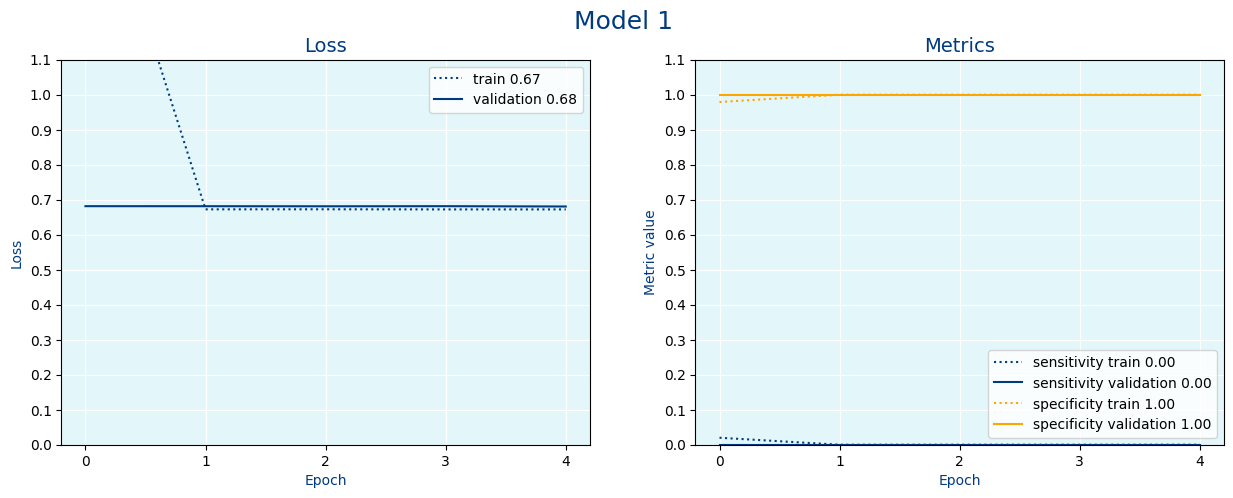

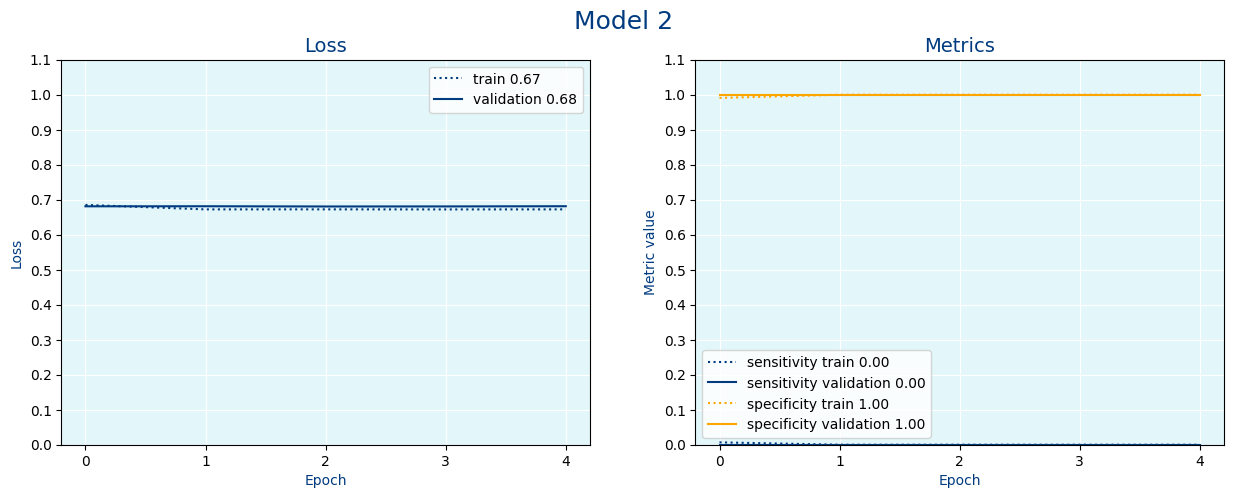

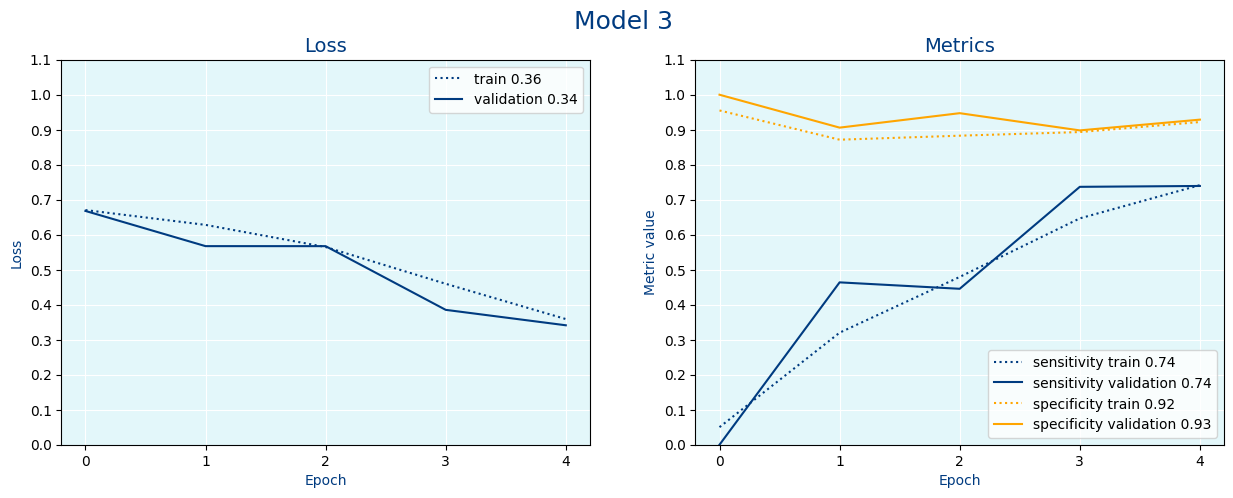

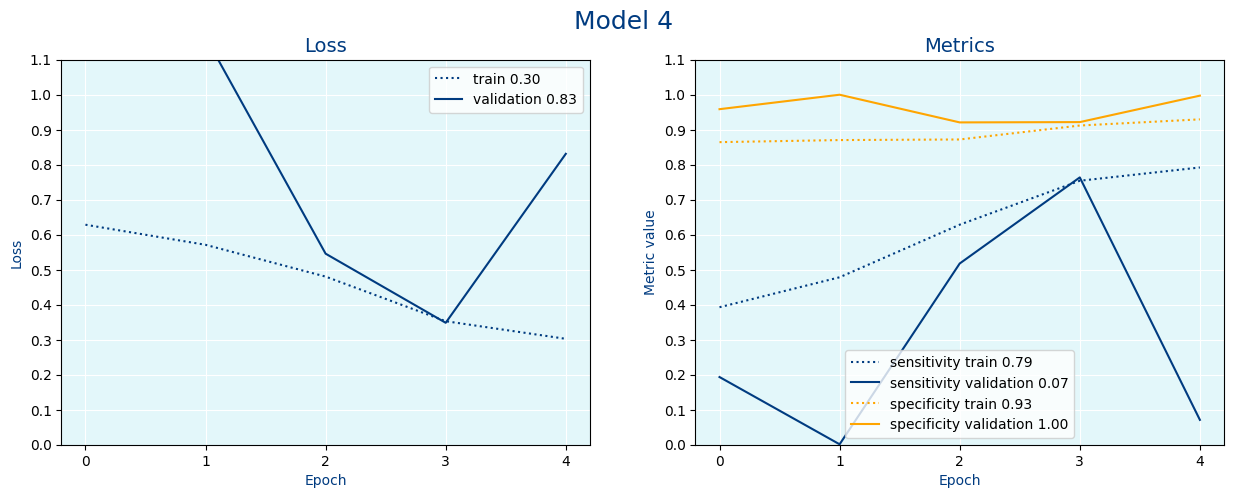

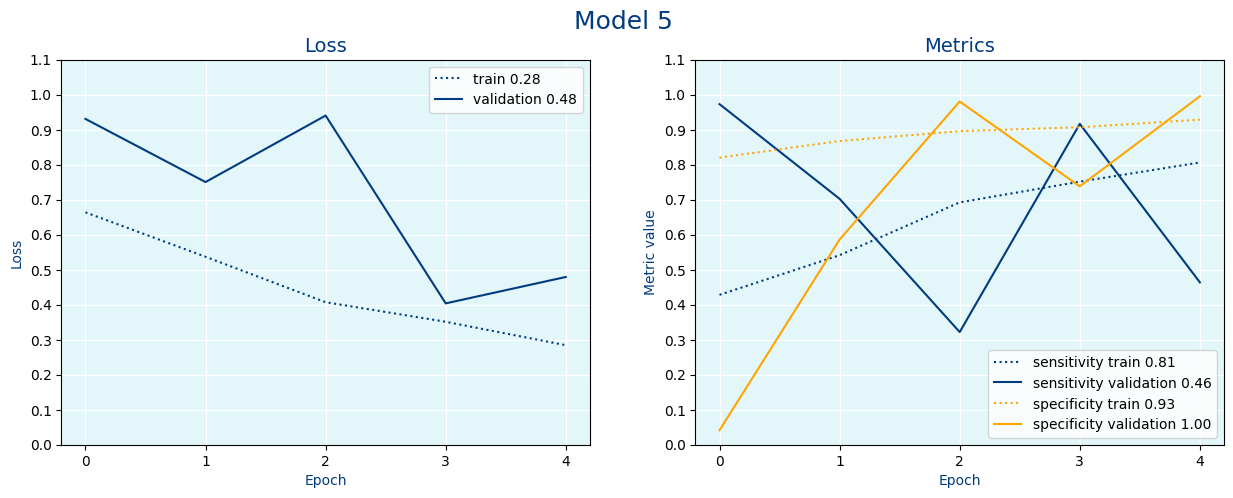

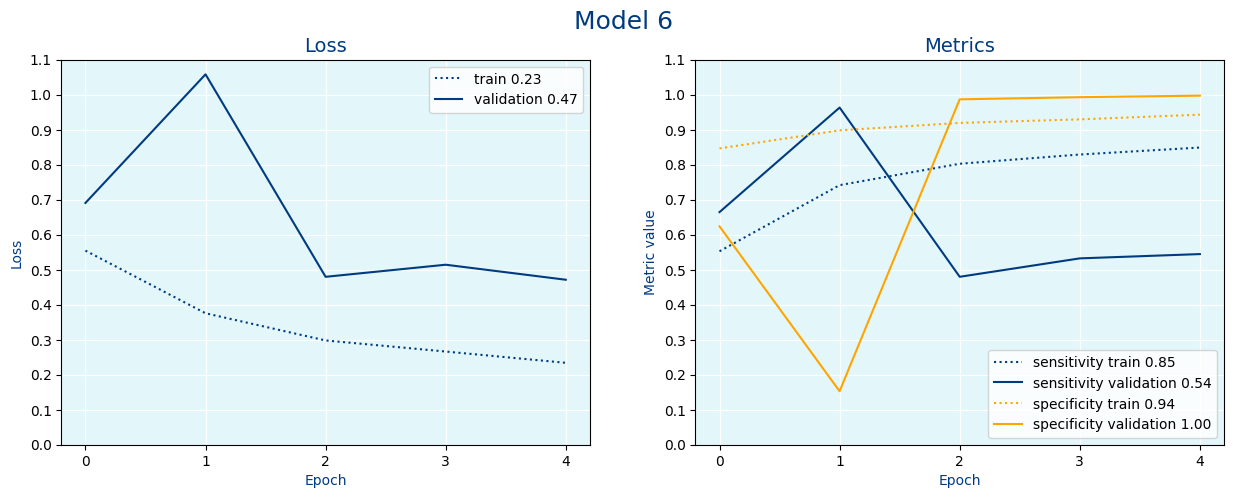

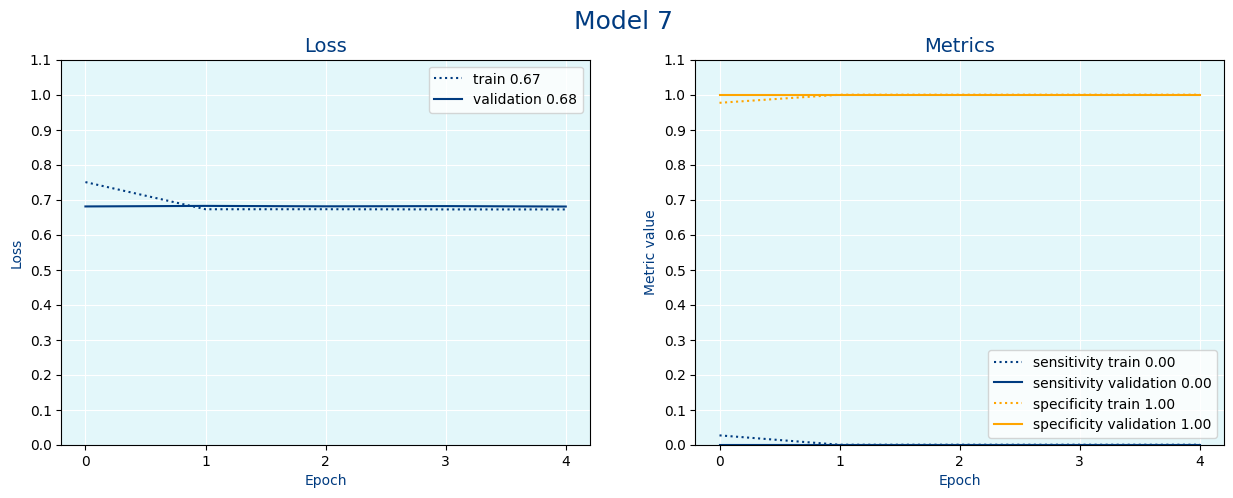

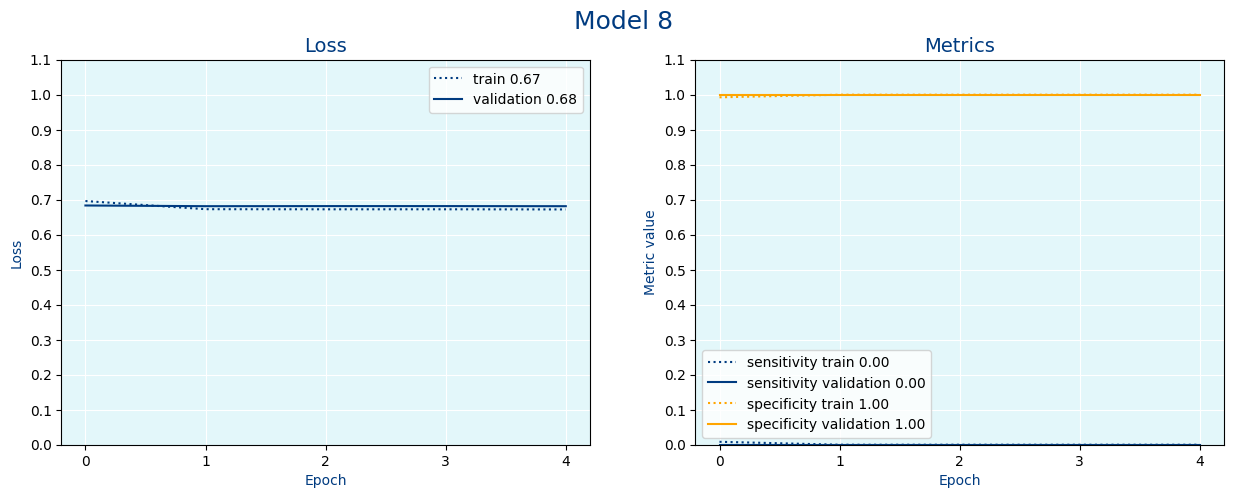

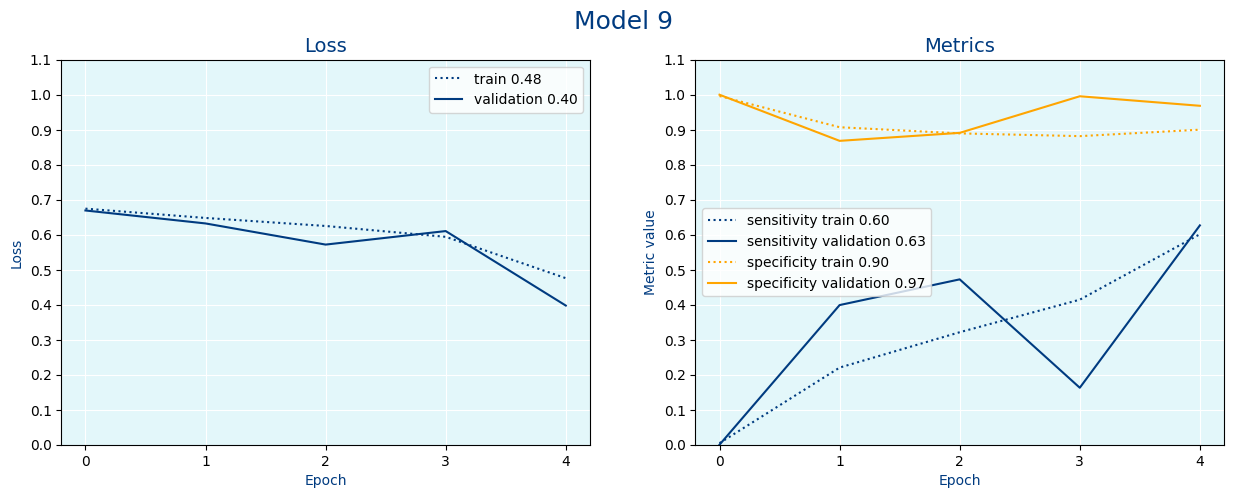

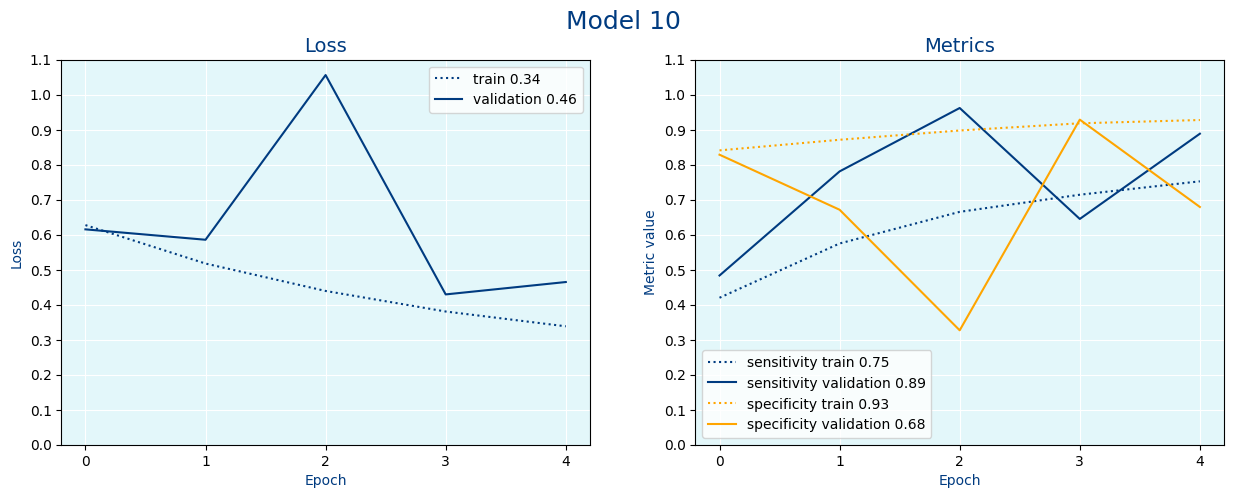

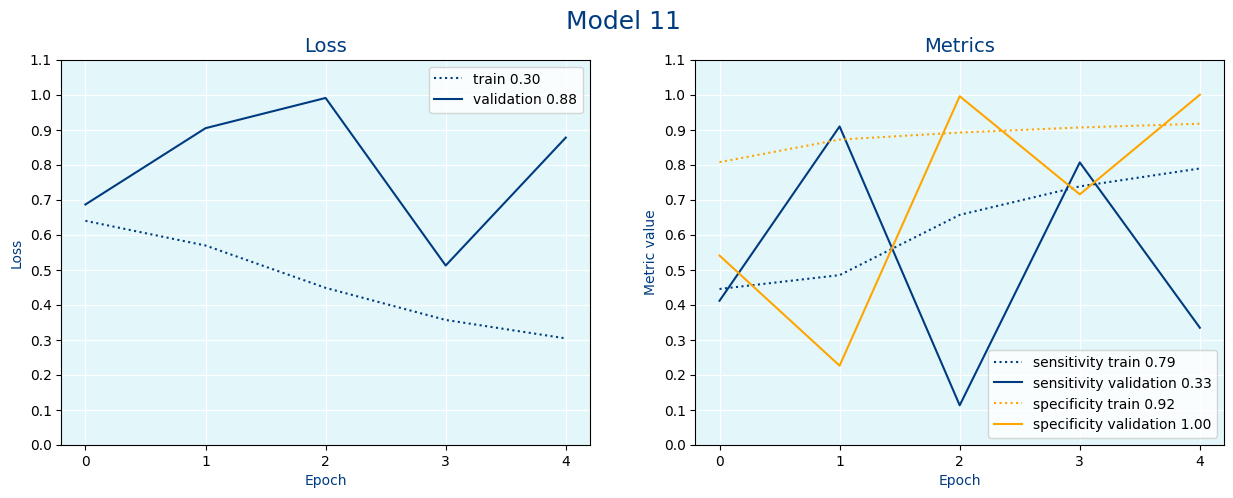

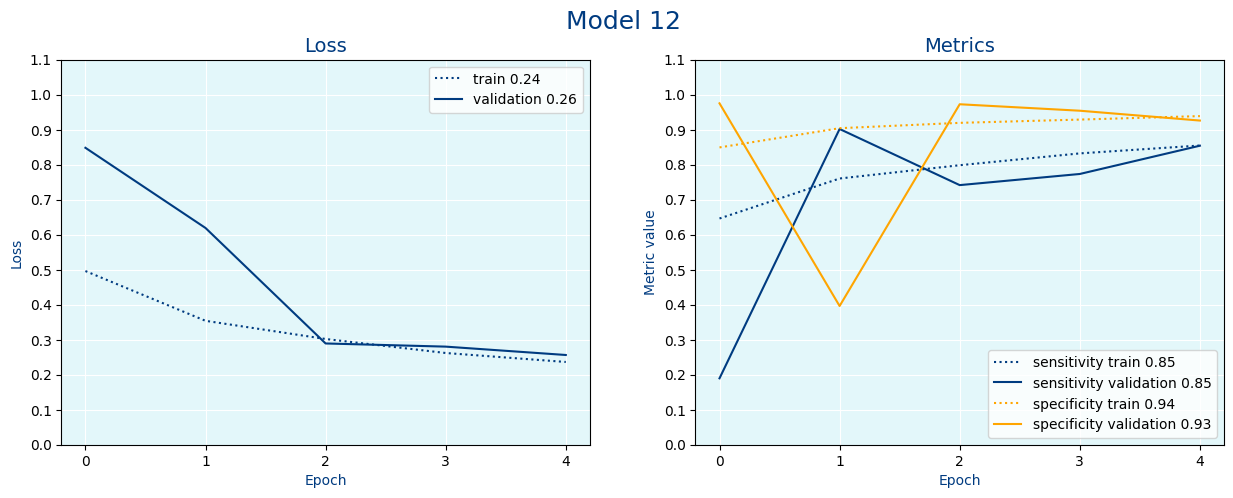

In [29]:
for idx, history in enumerate(histories):
    fig = plot_losses_and_metrics(history, f'Model {idx + 1}')

In [30]:
def plot_intervals(axes, intervals, title: str, x_label: str, y_labels: list):
    for index, (inferior, superior) in enumerate(intervals):
        position = len(intervals) - index - 1
        average = ((superior - inferior) / 2) + inferior
        axes.plot([inferior, superior], [position, position], marker='|', markersize=10, linestyle='-')
        axes.scatter(average, position)

    axes.set_yticks(np.arange(len(y_labels)))
    axes.set_yticklabels(y_labels[::-1])

    axes.set_xlabel(x_label, color='#003B80')
    axes.set_xlim(0, 1)
    axes.xaxis.set_major_locator(MultipleLocator(.1))

    axes.set_title(title, fontsize=14, color='#003B80')

    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=1)

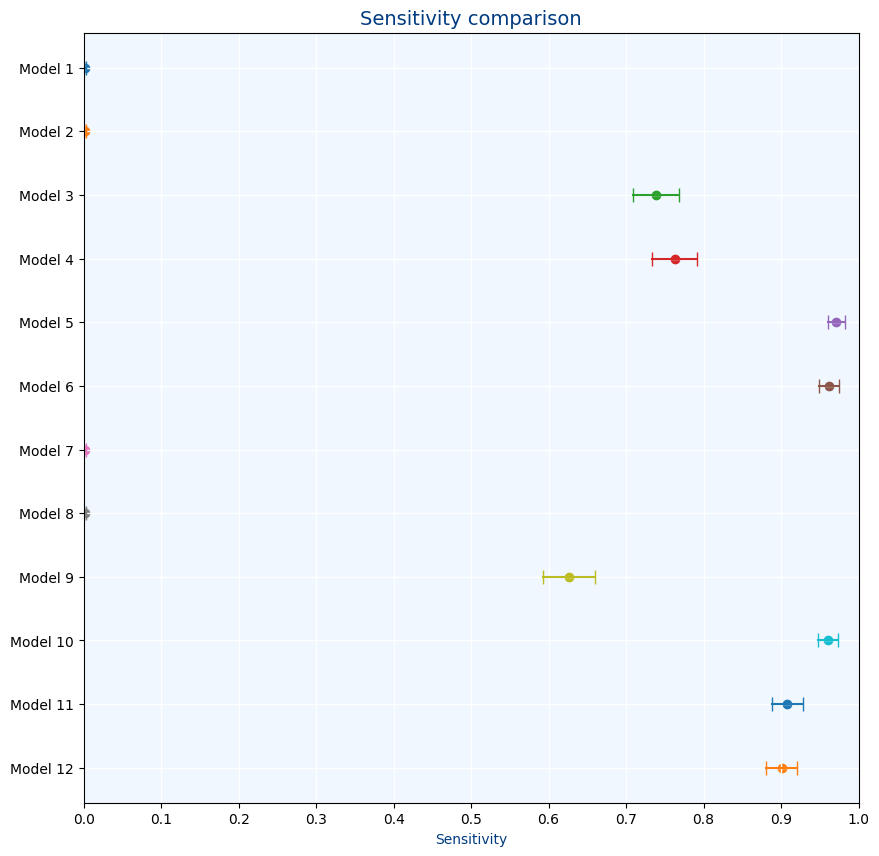

In [31]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

confidence_intervals = []
for history in histories:
    tp = np.array(history.history['val_tp'])
    fn = np.array(history.history['val_fn'])
    specificity = tp / (tp + fn)
    best_epoch = np.argmax(specificity)
    lower, upper = proportion_confint(tp[best_epoch], tp[best_epoch] + fn[best_epoch], alpha=0.05, method='jeffreys')
    confidence_intervals.append((lower, upper))

y_labels = [f'Model {i + 1}' for i in range(12)]

plot_intervals(axes, confidence_intervals, 'Sensitivity comparison', 'Sensitivity', y_labels)

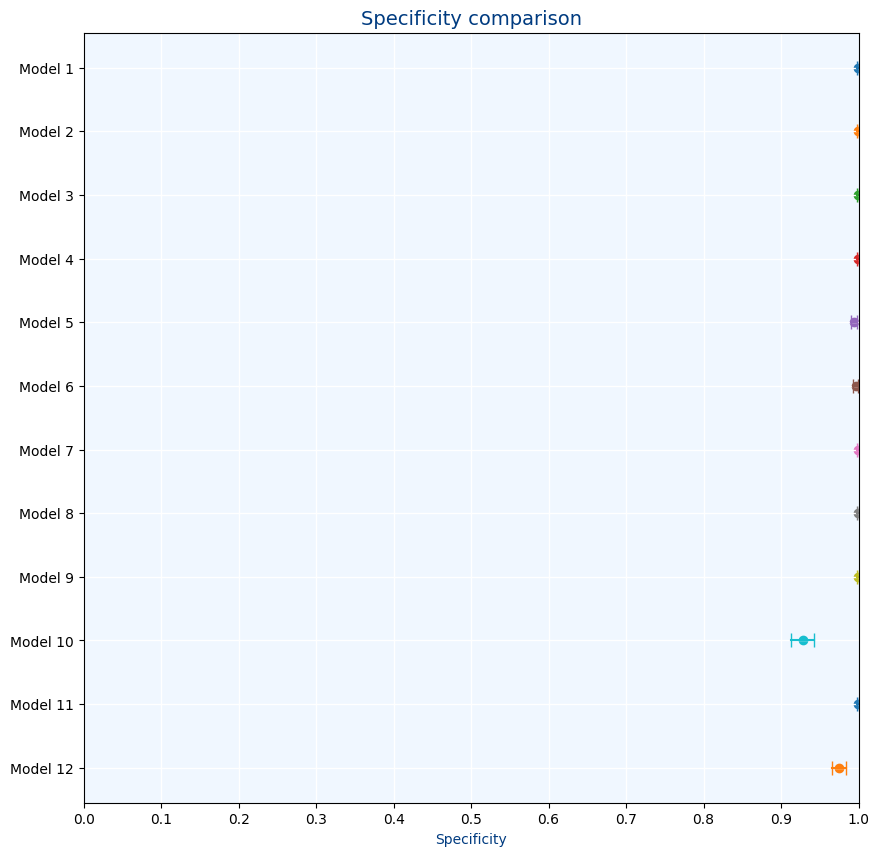

In [32]:
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot()

confidence_intervals = []
for history in histories:
    tn = np.array(history.history['val_tn'])
    fp = np.array(history.history['val_fp'])
    specificity = tn / (tn + fp)
    best_epoch = np.argmax(specificity)
    lower, upper = proportion_confint(tn[best_epoch], tn[best_epoch] + fp[best_epoch], alpha=0.05, method='jeffreys')
    confidence_intervals.append((lower, upper))

y_labels = [f'Model {i + 1}' for i in range(12)]

plot_intervals(axes, confidence_intervals, 'Specificity comparison', 'Specificity', y_labels)

### Model choice

In order to choose the best model, we will focus on the sensitivity metric. The main reasons to choose this method are:
- The metric is independent of the prevalence and, for our problem, this is specially important since the train dataset is unbalanced towards more adult picture but in production, it will be unbalanced towards more minor pictures.
- It is important to maximize the number of true positives to avoid minors appear in the import. Even if this could cause more false negatives, it will always be better to pixelate out an adult from the picture rather than not pixelating a minor.

The model that gives the best results is model 12.

In [34]:
best_model = model_12

Train the model more epochs, until there is no improvement in the validation loss

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{PATH_MODELS}/my_model.keras',
    save_best_only=True,
    monitor='val_recall',
    mode='max',
)

best_model_history = best_model.fit(train_ds, validation_data=validation_ds, epochs=100, batch_size=32, verbose=False,
                                    callbacks=[early_stopping, model_checkpoint])

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


In [36]:
thresholds = np.linspace(0, 1, 100)

sensitivities = []
specificities = []

y_scores = best_model.predict(validation_ds, verbose=False)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

for threshold in thresholds:
    y_pred = y_scores > threshold

    tp = np.sum(y_pred & y_true)
    fn = np.sum(~y_pred & y_true)
    tn = np.sum(~y_pred & ~y_true)
    fp = np.sum(y_pred & ~y_true)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sensitivities.append(sensitivity)
    specificities.append(specificity)


In [37]:
def plot_threshold_vs_metrics(thresholds, sensitivities, specificities):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(thresholds, sensitivities, label='Sensitivity', color='#003B80')
    ax.plot(thresholds, specificities, label='Specificity', color='#FFA500')

    ax.set_title('Threshold vs Sensitivity and Specificity', fontsize=14, color='#003B80')
    ax.set_xlabel('Threshold', color='#003B80')
    ax.set_ylabel('Metric value', color='#003B80')

    ax.set_facecolor("#E3F7FA")
    ax.grid(visible=True, which='major', axis='both', color='white')
    ax.set_axisbelow(True)
    ax.legend()

    return fig

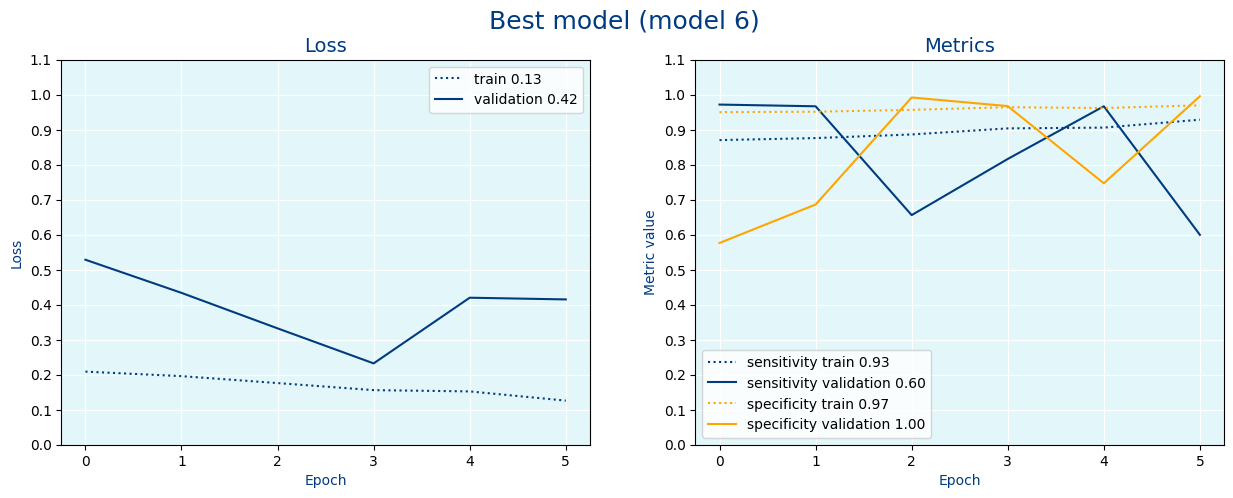

In [38]:
_ = plot_losses_and_metrics(best_model_history, 'Best model (model 12)')

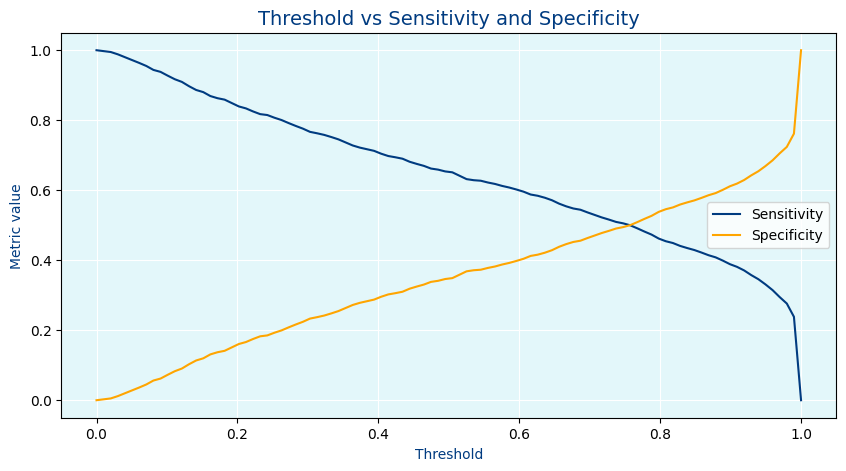

In [39]:
_ = plot_threshold_vs_metrics(thresholds, sensitivities, specificities)

The best threshold for our problem will be around 0.1, as explained above, we want to maximize the number of true positives so there are no minors in the final picture. This threshold has almost the highest sensitivity, and even if the specificity is rather low, it is not our main goal.

In [40]:
best_threshold_model = 0.1

y_scores = best_model.predict(validation_ds, verbose=False)
y_pred = y_scores > best_threshold_model

tp = np.sum(y_pred & y_true)
fn = np.sum(~y_pred & y_true)
tn = np.sum(~y_pred & ~y_true)
fp = np.sum(y_pred & ~y_true)

best_sensitivity_interval = proportion_confint(tp, tp + fn, alpha=0.05, method='jeffreys')
best_specificity_interval = proportion_confint(tn, tn + fp, alpha=0.05, method='jeffreys')

Now you are going to re-create the model using knowledge transfer. For this you use the pre-trained MobileNetV2 model. To perform knowledge transfer, you have to perform the phases of both feature extraction and fine tuning.

**Feature extraction**

In [41]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE))
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

input = layers.Input(shape=IMG_SIZE)

x = preprocess_input(input)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_transfer_knowledge = Model(inputs=[input], outputs=[output])

model_transfer_knowledge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        Recall(name='recall'),
        TruePositives(name='tp'),
        TrueNegatives(name='tn'),
        FalsePositives(name='fp'),
        FalseNegatives(name='fn'),
    ]
)

history_transfer_knowledge = model_transfer_knowledge.fit(train_ds, validation_data=validation_ds, epochs=50,
                                                          batch_size=32, verbose=False)

9406464/9406464 [==============================] - 2s 0us/step


**Fine tuning**

In [42]:
base_model.trainable = True

model_transfer_knowledge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        Recall(name='recall'),
        TruePositives(name='tp'),
        TrueNegatives(name='tn'),
        FalsePositives(name='fp'),
        FalseNegatives(name='fn'),
    ]
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{PATH_MODELS}/mobilenet_model.keras',
    save_best_only=True,
    monitor='val_recall',
    mode='max',
)

history_fine_tuning = model_transfer_knowledge.fit(train_ds, validation_data=validation_ds, epochs=100, batch_size=32,
                                                   verbose=False, callbacks=[early_stopping, model_checkpoint])

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


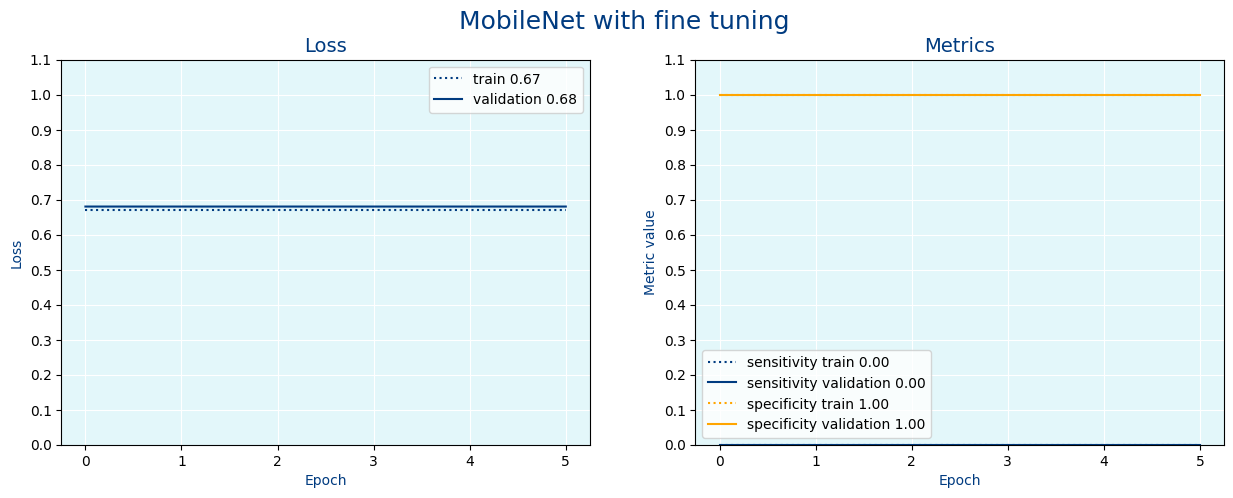

In [43]:
_ = plot_losses_and_metrics(history_fine_tuning, 'MobileNet with fine tuning')

In [44]:
thresholds_mobilenet = np.linspace(0, 1, 100)

sensitivities_mobilenet = []
specificities_mobilenet = []

y_scores_mobilenet = model_transfer_knowledge.predict(validation_ds, verbose=False)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

for threshold in thresholds_mobilenet:
    y_pred = y_scores_mobilenet > threshold

    tp = np.sum(y_pred & y_true)
    fn = np.sum(~y_pred & y_true)
    tn = np.sum(~y_pred & ~y_true)
    fp = np.sum(y_pred & ~y_true)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sensitivities_mobilenet.append(sensitivity)
    specificities_mobilenet.append(specificity)

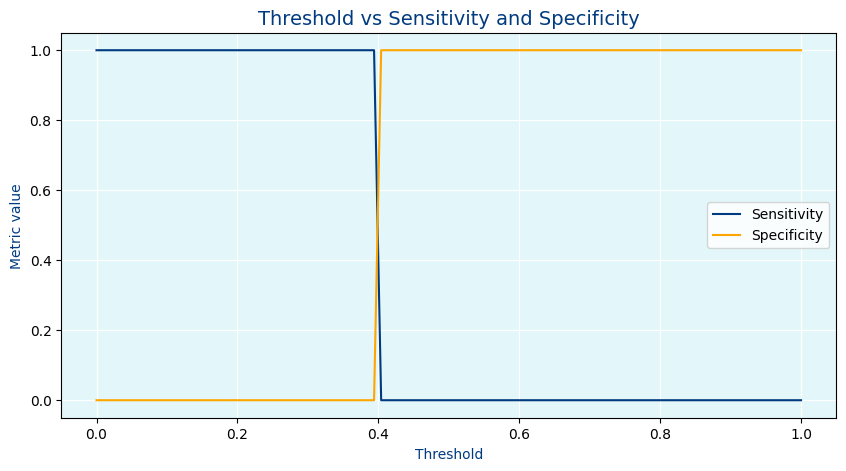

In [45]:
_ = plot_threshold_vs_metrics(thresholds_mobilenet, sensitivities_mobilenet, specificities_mobilenet)

The best threshold for our problem will be around 0.3 for the reasons explained above in the previous model.

In [46]:
best_threshold_mobilenet_model = 0.3

y_pred = y_scores_mobilenet > best_threshold_mobilenet_model

tp = np.sum(y_pred & y_true)
fn = np.sum(~y_pred & y_true)
tn = np.sum(~y_pred & ~y_true)
fp = np.sum(y_pred & ~y_true)

best_mobilenet_sensitivity_interval = proportion_confint(tp, tp + fn, alpha=0.05, method='jeffreys')
best_mobilenet_specificity_interval = proportion_confint(tn, tn + fp, alpha=0.05, method='jeffreys')

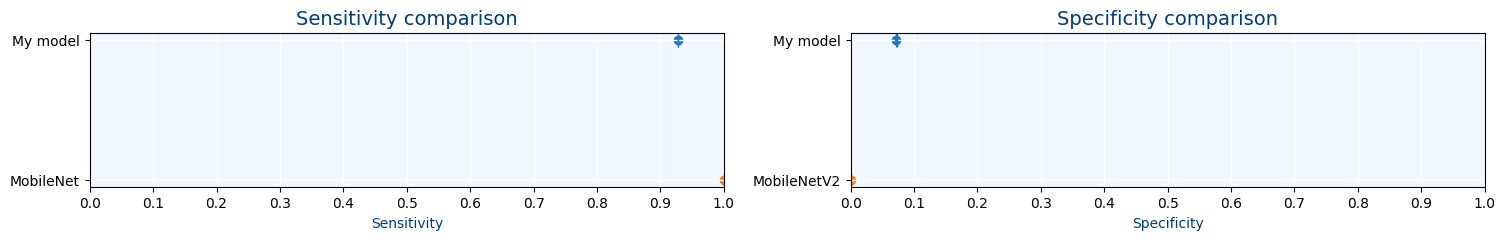

In [47]:
figure = plt.figure(figsize=(18, 2))
axe_sensitivity = figure.add_subplot(1, 2, 1)

plot_intervals(
    axe_sensitivity,
    [best_sensitivity_interval, best_mobilenet_sensitivity_interval],
    'Sensitivity comparison',
    'Sensitivity',
    ['My model', 'MobileNet']
)

axe_specificity = figure.add_subplot(1, 2, 2)
plot_intervals(
    axe_specificity,
    [best_specificity_interval, best_mobilenet_specificity_interval],
    'Specificity comparison',
    'Specificity',
    ['My model', 'MobileNetV2']
)

### Compare with the dataset with only 16 and 17 yo

In [48]:
y_true_16_17 = np.concatenate([y for x, y in minor_16_17_ds], axis=0)

In [49]:
y_scores_16_17_my_model = best_model.predict(minor_16_17_ds, verbose=False)
y_pred_16_17_my_model = y_scores_16_17_my_model > best_threshold_model

tp_16_17_my_model = np.sum(y_pred_16_17_my_model & y_true_16_17)
fn_16_17_my_model = np.sum(~y_pred_16_17_my_model & y_true_16_17)
tn_16_17_my_model = np.sum(~y_pred_16_17_my_model & ~y_true_16_17)
fp_16_17_my_model = np.sum(y_pred_16_17_my_model & ~y_true_16_17)

sensitivity_16_17_my_model = tp_16_17_my_model / (tp_16_17_my_model + fn_16_17_my_model)
specificity_16_17_my_model = tn_16_17_my_model / (tn_16_17_my_model + fp_16_17_my_model)

sensitivity_16_17_my_model_interval = proportion_confint(tp_16_17_my_model, tp_16_17_my_model + fn_16_17_my_model,
                                                         alpha=0.05, method='jeffreys')
specificity_16_17_my_model_interval = proportion_confint(tn_16_17_my_model, tn_16_17_my_model + fp_16_17_my_model,
                                                         alpha=0.05, method='jeffreys')


<ipython-input-49-68948eea6d45>:10: RuntimeWarning: invalid value encountered in scalar divide
  specificity_16_17_my_model = tn_16_17_my_model / (tn_16_17_my_model + fp_16_17_my_model)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a


In [50]:

y_scores_16_17_mobilenet = model_transfer_knowledge.predict(minor_16_17_ds, verbose=False)
y_pred_16_17_mobilenet = y_scores_16_17_mobilenet > best_threshold_mobilenet_model

tp_16_17_mobilenet = np.sum(y_pred_16_17_mobilenet & y_true_16_17)
fn_16_17_mobilenet = np.sum(~y_pred_16_17_mobilenet & y_true_16_17)
tn_16_17_mobilenet = np.sum(~y_pred_16_17_mobilenet & ~y_true_16_17)
fp_16_17_mobilenet = np.sum(y_pred_16_17_mobilenet & ~y_true_16_17)

sensitivity_16_17_mobilenet = tp_16_17_mobilenet / (tp_16_17_mobilenet + fn_16_17_mobilenet)
specificity_16_17_mobilenet = tn_16_17_mobilenet / (tn_16_17_mobilenet + fp_16_17_mobilenet)

sensitivity_16_17_mobilenet_interval = proportion_confint(tp_16_17_mobilenet, tp_16_17_mobilenet + fn_16_17_mobilenet,
                                                          alpha=0.05, method='jeffreys')
specificity_16_17_mobilenet_interval = proportion_confint(tn_16_17_mobilenet, tn_16_17_mobilenet + fp_16_17_mobilenet,
                                                          alpha=0.05, method='jeffreys')


<ipython-input-50-7aebc14eacc8>:10: RuntimeWarning: invalid value encountered in scalar divide
  specificity_16_17_mobilenet = tn_16_17_mobilenet / (tn_16_17_mobilenet + fp_16_17_mobilenet)


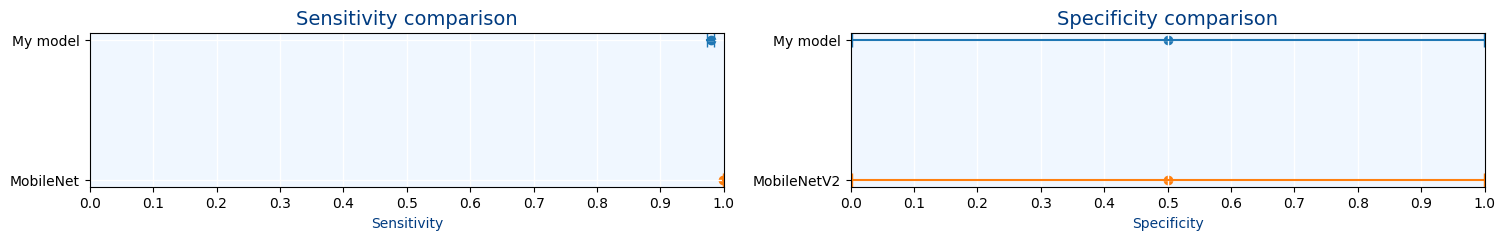

In [51]:
figure = plt.figure(figsize=(18, 2))
axe_sensitivity = figure.add_subplot(1, 2, 1)

plot_intervals(
    axe_sensitivity,
    [sensitivity_16_17_my_model_interval, sensitivity_16_17_mobilenet_interval],
    'Sensitivity comparison',
    'Sensitivity',
    ['My model', 'MobileNet']
)

axe_specificity = figure.add_subplot(1, 2, 2)
plot_intervals(
    axe_specificity,
    [specificity_16_17_my_model_interval, specificity_16_17_mobilenet_interval],
    'Specificity comparison',
    'Specificity',
    ['My model', 'MobileNetV2']
)